# Task 4: Proxy Target Engineering Notebook
This notebook demonstrates creation of a proxy credit-risk target using RFM clustering, then integrates it into the feature set for downstream modeling.

## 1. Load Dependencies and Data
Import core libraries and load the raw transactions dataset.

In [9]:
# Imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# Ensure project root on sys.path (assumes notebook lives in repo/notebooks)
ROOT = Path.cwd().resolve().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.data_processing import calculate_rfm, create_proxy_target, add_proxy_to_features

DATA_PATH = ROOT / "data" / "raw" / "data.csv"
assert DATA_PATH.exists(), f"Missing file: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


## 2. Explore and Clean Dataset
Inspect schema, missingness, and basic distributions relevant for RFM.

In [10]:
df.info()

missing = df.isna().mean().sort_values(ascending=False)
missing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

TransactionId     0.0
BatchId           0.0
AccountId         0.0
SubscriptionId    0.0
CustomerId        0.0
dtype: float64

## 3. Feature Engineering for Credit Risk (RFM Proxy Target)
Compute Recency, Frequency, Monetary features and cluster to derive the proxy `is_high_risk`.

        CustomerId  Recency  Frequency  Monetary  Monetary_abs  \
0     CustomerId_1       84          1  -10000.0         10000   
1    CustomerId_10       84          1  -10000.0         10000   
2  CustomerId_1001       90          5   20000.0         30400   
3  CustomerId_1002       26         11    4225.0          4775   
4  CustomerId_1003       12          6   20000.0         32000   

   Monetary_positive  
0                0.0  
1                0.0  
2            25200.0  
3             4500.0  
4            26000.0  
Cluster Summary (mean values):
           Recency  Frequency_log  Monetary_abs_log
cluster                                            
1        60.863333       1.227759          8.455147
0        21.858311       1.935131         10.153124
2        11.735568       3.828521         12.202124


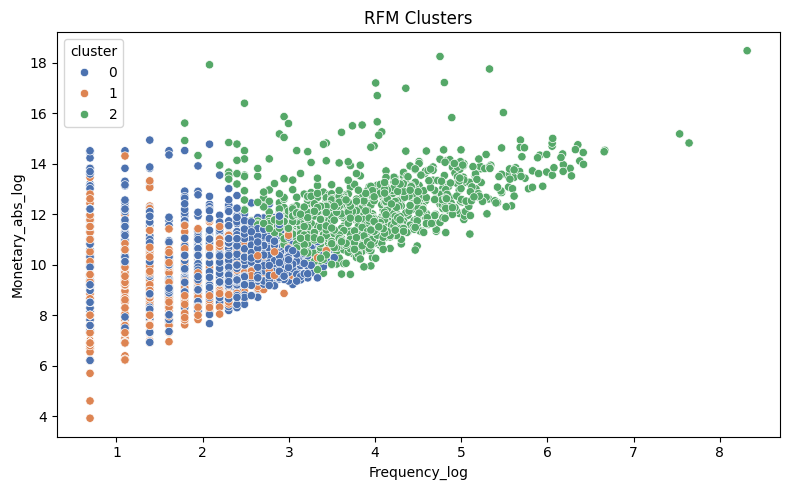

Selected high-risk cluster: 1
Proxy target distribution (%):
is_high_risk
0    67.93
1    32.07
Name: proportion, dtype: float64
        CustomerId  is_high_risk  cluster  Recency  Frequency  Monetary  \
0     CustomerId_1             1        1       84          1  -10000.0   
1    CustomerId_10             1        1       84          1  -10000.0   
2  CustomerId_1001             1        1       90          5   20000.0   
3  CustomerId_1002             0        0       26         11    4225.0   
4  CustomerId_1003             0        0       12          6   20000.0   

   Monetary_abs  Monetary_positive  
0         10000                0.0  
1         10000                0.0  
2         30400            25200.0  
3          4775             4500.0  
4         32000            26000.0  
High-risk share: 0.32068412613575625
Saved proxy target to ..\data\processed\proxy_target.csv


In [12]:
rfm = calculate_rfm(df)
print(rfm.head())

proxy = create_proxy_target(rfm, n_clusters=3, random_state=42, plot=True)
print(proxy.head())
print("High-risk share:", proxy["is_high_risk"].mean())

out_path = Path("../data/processed/proxy_target.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
proxy.to_csv(out_path, index=False)
print(f"Saved proxy target to {out_path}")

## 4. Train/Validation Split
Prepare splits (placeholder here; integrate with full feature set downstream).

In [13]:
# Placeholder: merge proxy with existing customer features if available.
# customer_features = ...  # load your aggregated per-customer features
# full = add_proxy_to_features(customer_features, proxy)
# from sklearn.model_selection import train_test_split
# X_train, X_val = train_test_split(full, test_size=0.2, random_state=42, stratify=full["is_high_risk"])
pass

## 5. Model Training for PD Estimation
Use the proxy label `is_high_risk` as target once merged with features.

## 6. Model Evaluation (ROC-AUC, PR-AUC, Brier Score)
Evaluate downstream PD models; add plots once features are merged.

## 7. Probability Calibration
Apply calibration (e.g., Platt, isotonic) after model training if needed.

## 8. Cross-Validation & Hyperparameter Tuning
Use grid/random search on downstream models to improve PD performance.

## 9. Save Trained Model and Metrics
Persist the trained model(s) and calibration artifacts once built.